<a href="https://colab.research.google.com/github/KimSeonHo-719/CV/blob/main/20251_CV_HW3_BoVW_%E1%84%86%E1%85%AE%E1%86%AB%E1%84%8C%E1%85%A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2025-2 Computer Vision HW#3 - Bag-of-Visual-Words and Support Vector Machine - Seongwon Lee (Kookmin University)

## 1️. 이미지에서 특징 추출 및 Stack

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import cv2
import numpy as np
import os

# ORB (Oriented FAST and Rotated BRIEF) 특징 추출기 사용
# ORB는 SIFT와 SURF의 대안으로, 빠르고 효율적이며, OpenCV에서 무료로 사용 가능
def extract_orb_features_with_keypoints(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(img, None)
    return keypoints, descriptors

# 각 이미지에서 특징을 추출하고, 특징과 이미지 경로를 저장하는 함수
def extract_descritpors_from_folder(folder_path):
    descriptor_list = []
    keypoints_list = []
    image_paths = []

    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            kps, descs = extract_orb_features_with_keypoints(img_path)
            if descs is not None:
                descriptor_list.append(descs)
                keypoints_list.append(kps)
                image_paths.append((img_path, class_name))

    return descriptor_list, keypoints_list, image_paths

train_descriptors, train_keypoints, train_paths = extract_descritpors_from_folder("/content/drive/MyDrive/Colab Notebooks/train")
print(f"총 {len(train_descriptors)}개의 이미지에서 특징을 추출했습니다.")


총 120개의 이미지에서 특징을 추출했습니다.


## 2️. KMeans로 Visual Vocabulary 생성

In [ ]:

# 모든 train image descriptor를을 하나의 배열로 결합
all_descriptors = np.vstack(train_descriptors)

# 클러스터 개수 (변경 가능)
num_clusters = 5

# # KMeans 클러스터링
def k_means(X, k, max_iters=100):
    # 1. 초기 중심점 선택
    tol=1e-4
    centers = X[np.random.choice(len(X), k, replace=False)]
    for it in range(max_iters):
      # 2. 각 샘풀을 가장 가까운 중심점에 할당
      distances=np.linalg.norm(X[:, None]-centers[None, :], axis=2) # (N,k)
      labels=np.argmin(distances, axis=1)
      # 3. 각 클러스터별 새로운 중심점 계산
      new_centers=np.vstack([X[labels==i].mean(axis=0) if np.any(labels==i) else centers[i]
                             for i in range(k)]) # (k,D)
      # 4. 수렴 여부, 중심점 이동거리 확인
      shifts=np.linalg.norm(new_centers-centers, axis=1)
      if np.max(shifts)<tol:
        centers=new_centers
        break
      centers=new_centers
    # TODO: 클러스터링 알고리즘 구현

    return labels, centers

labels, centers = k_means(all_descriptors, num_clusters)
print("클러스터 학습 완료")


클러스터 학습 완료


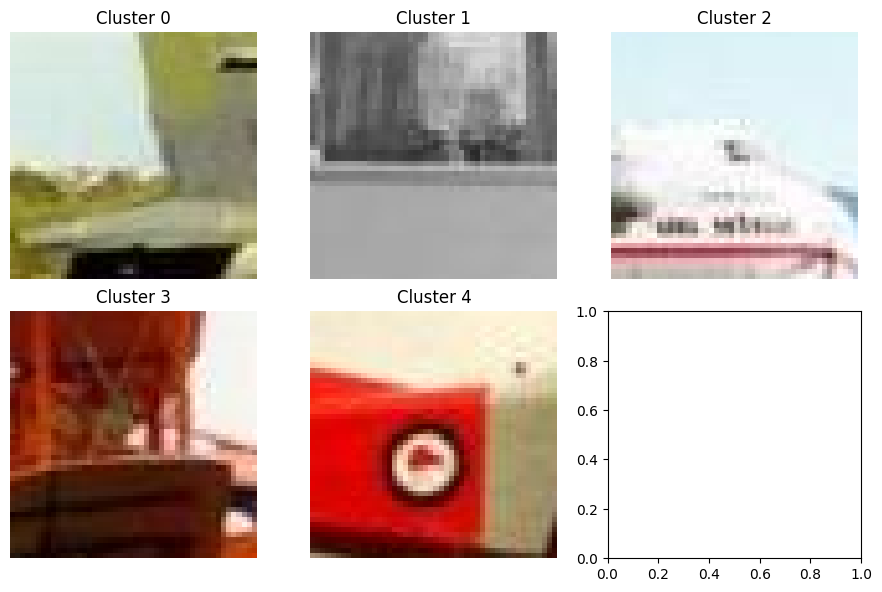

In [ ]:
import matplotlib.pyplot as plt
import math

# cluster를 대표하는 이미지 패치 시각화
def visualize_cluster_representatives(descriptors, image_paths, keypointss, centers, cluster_num=10, patch_size=24):
    closest_dists = [np.inf] * cluster_num
    closest_imgs = [None] * cluster_num
    closest_pts = [None] * cluster_num

    for i, descriptors in enumerate(descriptors):
        if descriptors is None:
            continue
        img = cv2.imread(image_paths[i][0])
        keypoints = keypointss[i]

        for j, desc in enumerate(descriptors):
            distances = np.linalg.norm(centers - desc, axis=1)
            closest = np.argmin(distances)
            dist = distances[closest]

            if dist < closest_dists[closest]:
                closest_dists[closest] = dist
                closest_imgs[closest] = img
                if keypoints:
                    pt = keypoints[j].pt
                    closest_pts[closest] = (int(pt[0]), int(pt[1]))

    # 자동으로 행, 열 설정
    cols = math.ceil(math.sqrt(cluster_num))
    rows = math.ceil(cluster_num / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    for i in range(cluster_num):
        row, col = divmod(i, cols)
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')
        if closest_imgs[i] is not None and closest_pts[i] is not None:
            x, y = closest_pts[i]
            patch = closest_imgs[i][max(y-patch_size,0):y+patch_size, max(x-patch_size,0):x+patch_size]
            if patch.size > 0:
                ax.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
                ax.set_title(f"Cluster {i}")
        else:
            ax.set_title(f"Cluster {i} (N/A)")
    plt.tight_layout()
    plt.show()


visualize_cluster_representatives(train_descriptors, train_paths, train_keypoints, centers, cluster_num=num_clusters)


## 3️. 이미지마다 Bag-of-Visual-Words Histogram 생성

In [ ]:
# 히스토그램 생성
# 각 이미지에 대해 클러스터 중심과의 거리를 계산하여 가장 가까운 클러스터를 찾고, 해당 클러스터의 카운트를 증가시킴
def create_histogram(descriptors, centers):
    # TODO: 각 이미지에 대한 히스토그램 생성
    # 디스크립터 없는 경우 0 벡터
    if descriptors is None or len(descriptors)==0:
      return np.zeros(centers.shape[0],dtype=float)
    # 1. 각 디스크립터와 모든 중심점과의 거리 계산: (Ni, k)
    dists=np.linalg.norm(descriptors[:, None]-centers[None, :],axis=2)
    # 2. 가장 가까운 중심 인덱스 찾기
    assignments=np.argmin(dists,axis=1) # (Ni, )
    # 3. 히스토그램 카운팅
    k=centers.shape[0]
    histogram=np.bincount(assignments, minlength=k).astype(float) #(k, )
    # 4. L1 정규화
    histogram/=histogram.sum()
    return histogram


# train 데이터에 대해 히스토그램 생성
train_histograms = []
train_labels = []
label_map = {'airplanes': 0, 'cars': 1}

for i, (desc, (path, label)) in enumerate(zip(train_descriptors, train_paths)):
    hist = create_histogram(desc, centers)
    train_histograms.append(hist)
    train_labels.append(label_map[label])

X_train = np.array(train_histograms)
y_train = np.array(train_labels)


## 4️. SVM으로 학습하기

In [ ]:

from sklearn.svm import SVC as SVMClassfier

# SVM 분류기 생성 및 학습
svm = SVMClassfier(kernel='rbf') # SVM 분류기 생성
svm.fit(X_train, y_train) # SVM 학습
print("SVM 학습 완료")


SVM 학습 완료


## 5️. 테스트 이미지 평가

In [ ]:
# 테스트 데이터 로드 및 특징 추출
test_descriptors, test_keypoints, test_paths = extract_descritpors_from_folder("/content/drive/MyDrive/Colab Notebooks/test")

test_histograms = []
test_labels = []

for desc, (path, label) in zip(test_descriptors, test_paths):
    hist = create_histogram(desc, centers)
    test_histograms.append(hist)
    test_labels.append(label_map[label])

X_test = np.array(test_histograms)
y_test = np.array(test_labels)

# test data에 대해 SVM을 사용하여 label 예측
y_pred = svm.predict(X_test)


## 6. 평가 지표 및 Confusion Matrix 확인

TP: 41, TN: 46, FP: 14, FN: 19
Accuracy: 0.72
Precision: 0.75
Recall: 0.68


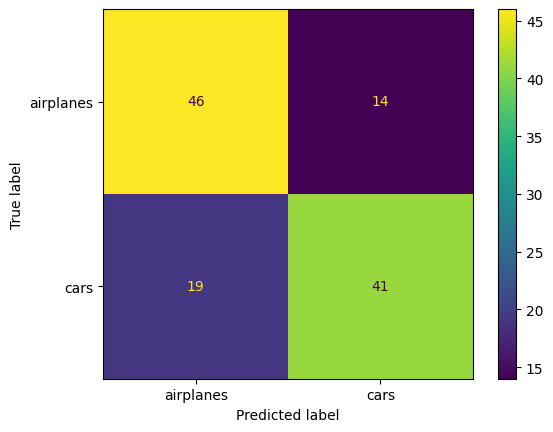

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# TODO: TP, TN, FP, FN 계산
tn,fp,fn,tp = confusion_matrix(y_test, y_pred).ravel()
TP,TN,FP,FN = tp,tn,fp,fn

print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

# TODO: TP, TN, FP, FN을 사용하여 Accuracy, Precision, Recall 계산

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())
disp.plot()
